# Deformed Potentials from Field Dependent Wavefunction Renormalization

In [1]:
# based on: https://arxiv.org/pdf/1811.10655.pdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import interp1d
#import sympy as sp
#sp.init_printing()
import sys
if ".." not in sys.path: sys.path.append("..")
from common.cosmology import switch_hubble_and_time_rad_dom as switch_hubble_and_time

## General Definitions

In [2]:
def calc_Z(theta, epsilon):
    return 2 / (1 + 2*epsilon**2 - np.cos(theta))

def calc_dZdtheta(theta, epsilon):
    return - 2*np.sin(theta) / (2*epsilon**2 - np.cos(theta) + 1)**2

def calc_U(theta):
    return 1 - np.cos(theta)

def calc_dUdtheta(theta):
    return np.sin(theta)

def calc_d_pot_d_theta(theta, m_a):
    return m_a**2 * calc_dUdtheta(theta)

def calc_pot(theta, m_a):
    return m_a**2 * calc_U(theta)

In [3]:
m_a = 1e-8 # a.u. for now
epsilon = 1e-3
theta_i = 1
# m_a**2 = Gamma**4 / f_a**2
# m_a = Gamma**2 / f_a

In [4]:
theta_range = np.linspace(-np.pi, np.pi, 1000)

Text(0, 0.5, '$Z(\\theta)$')

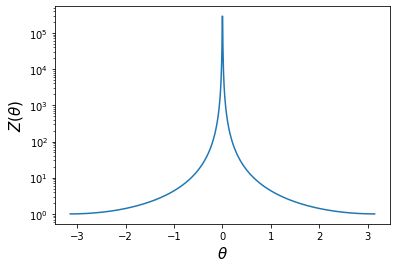

In [5]:
plt.semilogy(theta_range, calc_Z(theta_range, 1e-3))
plt.xlabel(r"$\theta$", fontsize=15)
plt.ylabel(r"$Z(\theta)$", fontsize=15)

## Simulation in $\theta$

In [6]:
def rhs_theta(t, y, m_a, epsilon):
    theta, theta_dot = y
    H = 1 / (2*t)
    Z = calc_Z(theta, epsilon)
    dZdtheta = calc_dZdtheta(theta, epsilon)
    theta_dotdot = - 1 / (2*Z) * dZdtheta * theta_dot**2 - 3*H*theta_dot - calc_d_pot_d_theta(theta, m_a) / Z
    return theta_dot, theta_dotdot

In [7]:
tspan = (switch_hubble_and_time(m_a * 1e2), switch_hubble_and_time(m_a * 1e-7))
steps = np.geomspace(*tspan, 1000); steps[0] = tspan[0]; steps[-1] = tspan[-1]
sol_theta = solve_ivp(rhs_theta, tspan, [theta_i, 0.0], args=(m_a, epsilon), rtol=1e-8, method="Radau", t_eval=steps)
assert sol_theta.success
t_theta = t = sol_theta.t; theta_theta, _ = theta, theta_dot = sol_theta.y

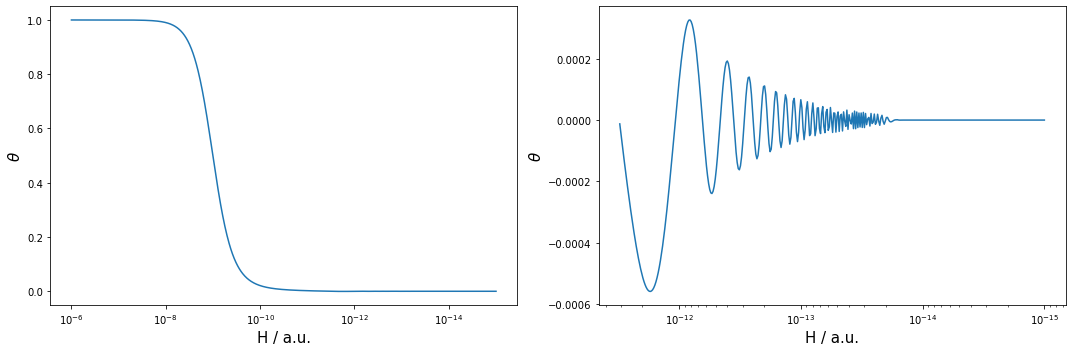

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.semilogx(switch_hubble_and_time(t), theta)
plt.gca().invert_xaxis()
plt.xlabel("H / a.u.", fontsize=15); plt.ylabel(r"$\theta$", fontsize=15)
plt.subplot(1,2,2)
fst_root_idx = np.where(theta < 0)[0][0]
plt.semilogx(switch_hubble_and_time(t[fst_root_idx:]), theta[fst_root_idx:])
plt.xlabel("H / a.u.", fontsize=15); plt.ylabel(r"$\theta$", fontsize=15)
plt.gca().invert_xaxis()
plt.tight_layout()

## Converting between $\theta$ and $\phi$

In [9]:
def calc_phi_from_theta(theta, epsilon):
    return quad(lambda x: np.sqrt(calc_Z(x, epsilon)), 0, theta)[0]

In [10]:
phis_over_f = [calc_phi_from_theta(theta, epsilon) for theta in theta_range]

Text(0, 0.5, '$\\phi / f_a$')

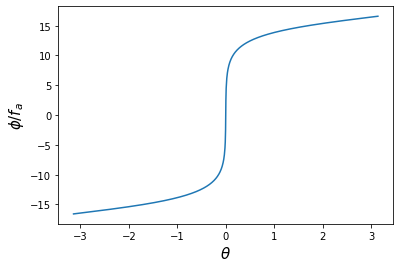

In [11]:
plt.plot(theta_range, phis_over_f)
plt.xlabel("$\\theta$", fontsize=15); plt.ylabel("$\\phi / f_a$", fontsize=15)

In [12]:
theta_to_phi_over_f_fn = interp1d(theta_range, phis_over_f)
phi_over_f_to_theta_fn = interp1d(phis_over_f, theta_range)

In [13]:
def calc_V_eff_over_f(phi_over_f, m_a):
    return calc_pot(phi_over_f_to_theta_fn(phi_over_f), m_a)

## Simulation in $\phi$

In [14]:
def rhs_phi(t, y, m_a):
    phi_over_f, phi_dot_over_f = y
    #print(phi_over_f)
    H = switch_hubble_and_time(t)
    theta = phi_over_f_to_theta_fn(phi_over_f)
    phi_dotdot_over_f = - 3 * H * phi_dot_over_f - calc_d_pot_d_theta(theta, m_a) / np.sqrt(calc_Z(theta, epsilon))
    return phi_dot_over_f, phi_dotdot_over_f

In [15]:
theta_to_phi_over_f_fn(theta_i)

array(13.85778526)

In [16]:
sol = solve_ivp(rhs_phi, tspan, [theta_to_phi_over_f_fn(theta_i), 0], t_eval=steps, args=(m_a,))
assert sol.success
t = sol.t
phi_over_f, phi_dot_over_f = sol.y

Text(0, 0.5, '$\\phi / f_a$')

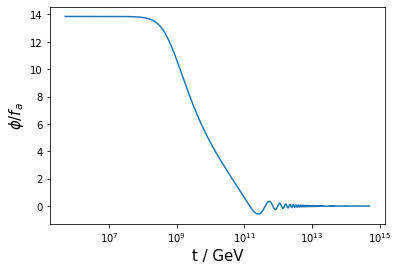

In [17]:
plt.semilogx(t, phi_over_f)
plt.xlabel("t / GeV", fontsize=15)
plt.ylabel("$\\phi / f_a$", fontsize=15)

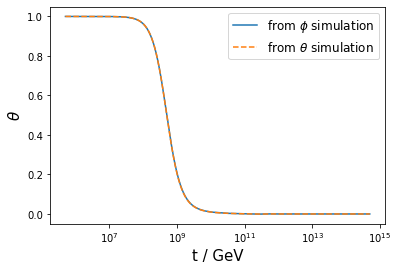

In [18]:
plt.semilogx(t, [phi_over_f_to_theta_fn(p) for p in phi_over_f], label="from $\\phi$ simulation")
plt.semilogx(t_theta, theta_theta, ls="--", label="from $\\theta$ simulation")
plt.xlabel("t / GeV", fontsize=15)
plt.ylabel("$\\theta$", fontsize=15)
plt.legend(fontsize=12)

## Analytic Approximations

$$
\ddot{\phi} + 3 H \dot{\phi} + \frac{\partial V_\mathrm{eff}(\phi)}{\partial \phi} = 0
$$

### Potential

Text(0, 0.5, '$V_\\mathrm{eff}$')

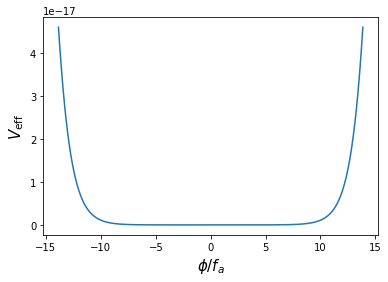

In [19]:
phi_over_f_range = np.linspace(theta_to_phi_over_f_fn(- theta_i), theta_to_phi_over_f_fn(theta_i), 200)
V_eff_over_f = calc_V_eff_over_f(phi_over_f_range, m_a)
plt.plot(phi_over_f_range, V_eff_over_f)
plt.xlabel("$\\phi / f_a$", fontsize=15)
plt.ylabel("$V_\\mathrm{eff}$", fontsize=15)

### Slow Roll and Fast Roll

https://arxiv.org/pdf/1107.6011.pdf

In [20]:
w = 1/3
c = 3 + 3*(w + 1)/2

$$
\dot{\phi} \sim - \frac{1}{c H(t)} \frac{\partial V_\mathrm{eff}(\phi)}{\partial \phi}  
$$

In [21]:
Z = calc_Z(theta, epsilon)
dZdtheta = calc_dZdtheta(theta, epsilon)
dUdtheta = calc_dUdtheta(theta)
d2Udtheta2 =  np.cos(theta)
d2Vdphi2 = m_a**2 * 1 / Z * (d2Udtheta2 - 1 / (2*Z) * dZdtheta * dUdtheta)
H = switch_hubble_and_time(t)
cond_slow_roll = np.abs(d2Vdphi2) / (5*H**2) 
H_FR = m_a / np.sqrt(5)

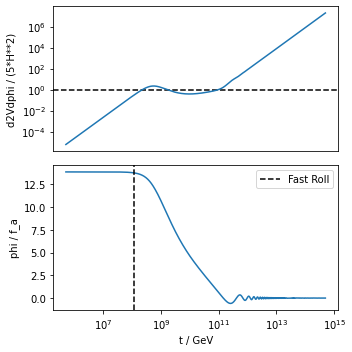

In [22]:
plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
plt.axhline(1, color="black", ls="--")
plt.loglog(t, cond_slow_roll)
plt.ylabel("d2Vdphi / (5*H**2)")
plt.xticks([])
plt.subplot(2,1,2)
plt.semilogx(t, phi_over_f)
plt.axvline(switch_hubble_and_time(H_FR), label="Fast Roll", ls="--", color="black")
plt.xlabel("t / GeV")
plt.ylabel("phi / f_a")
plt.legend()
plt.tight_layout()

Text(0, 0.5, '$\\dot{\\phi} / f_a$')

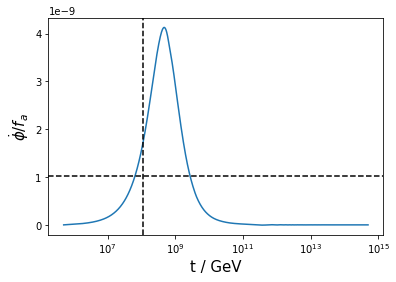

In [23]:
plt.semilogx(t, -phi_dot_over_f)
plt.axvline(switch_hubble_and_time(H_FR), ls="--", color="black")
plt.axhline(H_FR / calc_Z(theta_i, epsilon), ls="--", color="black")
plt.xlabel("t / GeV", fontsize=15)
plt.ylabel(r"$\dot{\phi} / f_a$", fontsize=15)

### Tracking

In [24]:
kin = 0.5 * phi_dot_over_f**2
pot = calc_V_eff_over_f(phi_over_f, m_a)
rho = kin + pot
P = kin - pot
w_phi = P / rho

In [25]:
n = 1
w_phi_tracking = (1 + w - n) / n

Text(0, 0.5, 'EOS w')

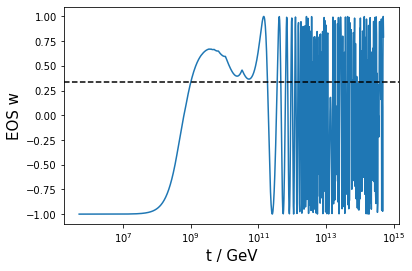

In [26]:
plt.semilogx(t, w_phi)
plt.axhline(w_phi_tracking, ls="--", color="black")
plt.xlabel("t / GeV", fontsize=15)
plt.ylabel("EOS w", fontsize=15)

In [27]:
phi_over_f_range = np.geomspace(theta_to_phi_over_f_fn(1e-3), theta_to_phi_over_f_fn(theta_i), 200)
V_eff_over_f = calc_V_eff_over_f(phi_over_f_range, m_a)

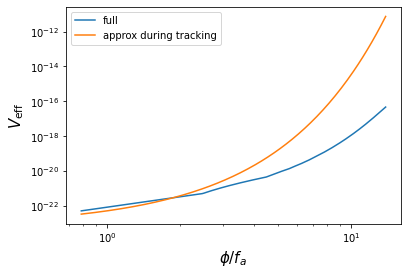

In [28]:
plt.plot(phi_over_f_range, V_eff_over_f, label="full")
V_eff_over_f2_tracking = 0.5 * epsilon**2 * m_a**2 * np.exp(2*np.abs(phi_over_f_range) - 2)
plt.plot(phi_over_f_range, V_eff_over_f2_tracking, label="approx during tracking")
plt.xlabel("$\\phi / f_a$", fontsize=15)
plt.ylabel("$V_\\mathrm{eff}$", fontsize=15)
plt.yscale("log")
plt.xscale("log")
plt.legend()

### Coherent Oscillations

In [29]:
m_phi = epsilon**n * m_a

In [30]:
V_eff_over_f2_osc = 0.5 * m_a**2 * phi_over_f_range**2

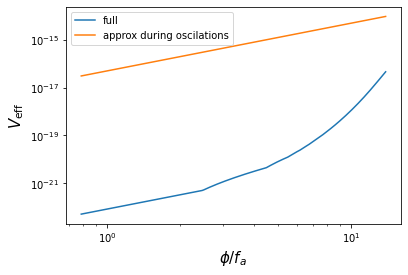

In [31]:
plt.plot(phi_over_f_range, V_eff_over_f, label="full")
plt.plot(phi_over_f_range, V_eff_over_f2_osc, label="approx during oscilations")
plt.xlabel("$\\phi / f_a$", fontsize=15)
plt.ylabel("$V_\\mathrm{eff}$", fontsize=15)
plt.yscale("log")
plt.xscale("log")
plt.legend()